In [10]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
from torch_geometric.loader import DataLoader
import os
from torch_geometric.nn import Sequential, GCNConv,GATConv
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time
import MyData as data
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import GNN_model

In [11]:
hidden_size = 64*10
num_ly=10
sel_alg=3
num_to_reduce=64
view='xz'
folder_pkl='bigger_event_GCN_2'


In [12]:
%%time
data=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed/')
if view=='xz':
    fname='pi-_10GeV_4ly_1e-4'
else:
    fname='pi-_10GeV_4ly_1e-4_yz'
data_trk=data.get_more_file(0,101,fname)#952,fname)
train_dataset = data_trk
val_dataset =data.get_more_file(130,151,fname)
test_dataset =data.get(160,fname)
print('len_train_dataset ',len(train_dataset))
print('len_val_dataset ',len(val_dataset))
print('len_test_dataset ',len(test_dataset))

taking a list of file from  0  to  101
taking a list of file from  130  to  151
taking the  data_160.pt
len_train_dataset  1009998
len_val_dataset  210000
len_test_dataset  10000
CPU times: user 3min 13s, sys: 13.5 s, total: 3min 27s
Wall time: 3min 29s


In [13]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
CPU times: user 8.61 ms, sys: 53.9 ms, total: 62.5 ms
Wall time: 201 ms


In [14]:
%%time
NUM_FEATURES = train_dataset[0].x.shape[1]
print(NUM_FEATURES)
NUM_CLASSES =1
n_ly=4
model_list=['SageConv','SageConv2','GCN','GCN_2','GAT']

5
CPU times: user 0 ns, sys: 132 µs, total: 132 µs
Wall time: 142 µs


In [15]:
outname=f'best_model{model_list[sel_alg]}_ly{n_ly}_view_{view}.pkl'

In [16]:
if sel_alg>len(model_list):
    print('no algorithm available')
if sel_alg==0:
    model = GNN_model.SageConv(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==1:
    model = GNN_model.SageConv2(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==2:
    model = GNN_model.GCN(num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==3:
    model = GNN_model.GCN_2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==4:
    model = GNN_model.GAT(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)

In [17]:
%%time
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
####criterion = torch.nn.CrossEntropyLoss()
criterion=torch.nn.functional.binary_cross_entropy#for sageconv

def train_model(train_data):
    model.to(device)
    model.train()
    for data in train_data:
        data.to(device)
        out = model(data) # Perform a single forward pass.
        labels=data.y.float().to(device)
        loss = criterion(out.squeeze(1).float(), labels)  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return model.to(device)

threshold=0.8
def evaluate_model(model,test_data):
    model.eval()
    correct = 0
    total_samples = 0
    model_outputs = []
    targets = []
    pred_class=[]

    for data in test_data:
        data.to(device)
        model_output = model(data)
        model_output.to(device)
        predicted_class = torch.where(model_output > threshold, 1, 0)
        
        correct += int((predicted_class == data.y.float()).sum())
        total_samples += len(data.y)

          # store these to get the loss
        model_outputs.extend(model_output.tolist())
        targets.extend(data.y.float().tolist())
        pred_class.extend(predicted_class.tolist())

    
    loss = criterion(torch.tensor(model_outputs).squeeze(1), torch.tensor(targets).float())
    accuracy = accuracy_score(targets, pred_class)
    precision = precision_score(targets, pred_class)
    recall = recall_score(targets, pred_class)
    
    return accuracy, loss, recall, precision 


CPU times: user 19.9 ms, sys: 364 ms, total: 384 ms
Wall time: 411 ms


In [18]:
test_batch_list=[]
start_value = 4032
increment = 64
iterations = 5
total_sum = 0

for i in range(iterations):
    current_value = start_value + (i* increment)
    
    test_batch_list.append(current_value)

In [19]:
test_batch_list.insert(0, 128)

In [20]:
test_batch_list

[128, 4032, 4096, 4160, 4224, 4288]

In [21]:
model

GCN_2(
  (conv_layers): ModuleList(
    (0): GCNConv(5, 640)
    (1): GCNConv(640, 576)
    (2): GCNConv(576, 512)
    (3): GCNConv(512, 448)
    (4): GCNConv(448, 384)
    (5): GCNConv(384, 320)
    (6): GCNConv(320, 256)
    (7): GCNConv(256, 192)
    (8): GCNConv(192, 128)
    (9): GCNConv(128, 64)
    (10): GCNConv(64, 1)
  )
)

In [22]:
%%time
try:
    times = []
    train_accuracies = []
    validation_accuracies = []
    validation_losses = []
    train_losses = []
    val_recall=[]
    val_precision=[]
    train_recall=[]
    train_precision=[]
    
    for batch_train in range(len(test_batch_list)):
        start = time.time()
        print('batch ',batch_train, test_batch_list[batch_train])
        train_loader = DataLoader(train_dataset, batch_size=test_batch_list[batch_train],shuffle=True,pin_memory=True,num_workers=15,drop_last=True) 
        val_loader=DataLoader(val_dataset, batch_size=128,shuffle=True,pin_memory=True,drop_last=True) 
        # test_loader=DataLoader(test_dataset, batch_size=64,shuffle=True)

        train_accuracies.append([])
        validation_accuracies.append([])
        validation_losses.append([])
        train_losses.append([])
        val_recall.append([])
        val_precision.append([])
        train_recall.append([])
        train_precision.append([])   
        
        
        for epoch in range(1, 3):
            start_epoch = time.time()
            print('epoch ',epoch)
            model = train_model(train_loader)
            print(next(model.parameters()).is_cuda)

            train_acc, train_loss, train_rec, train_prec = evaluate_model(model,train_loader)
            
            train_losses[batch_train].append(train_loss)

            val_acc, val_loss, val_rec, val_prec = evaluate_model(model,val_loader)
            validation_losses[batch_train].append(val_loss)

            train_accuracies[batch_train].append(train_acc)
            validation_accuracies[batch_train].append(val_acc)

            train_precision[batch_train].append(train_prec)
            train_recall[batch_train].append(train_rec)

            val_precision[batch_train].append(val_prec)
            val_recall[batch_train].append(val_rec)

            # save the model if it is the better than any previous ones
            if val_loss.item() <= min(validation_losses[batch_train]).item():
                # torch.save(model, f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/{folder_pkl}/{outname}')
                print(f'Epoch_stop: {epoch}')

            #torch.save(model, "best_model.pkl")
            if epoch % 1 == 0:
                print(f"Epoch {epoch}: Memoria GPU utilizzata: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")
                print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, time :{time.time() - start_epoch}')
        print(time.time() - start)
        times.append(time.time() - start)
        

except RuntimeError as e:
    if "CUDA out of memory" in str(e):
        print("Errore: Memoria CUDA esaurita per batch ", batch_train)
    else:
        # Gestione di altri tipi di RuntimeError
        print("Errore:", e)  

batch  0 128
epoch  1
True
Epoch_stop: 1
Epoch 1: Memoria GPU utilizzata: 0.03 GB
Epoch: 1, Train Acc: 0.5349, Train Loss: 0.5813, Val Acc: 0.5337, Val Loss: 0.5799, time :328.9779977798462
epoch  2
True
Epoch_stop: 2
Epoch 2: Memoria GPU utilizzata: 0.03 GB
Epoch: 2, Train Acc: 0.5349, Train Loss: 0.5734, Val Acc: 0.5337, Val Loss: 0.5728, time :341.7515468597412
670.7302343845367
batch  1 4032
epoch  1
True
Epoch_stop: 1
Epoch 1: Memoria GPU utilizzata: 0.03 GB
Epoch: 1, Train Acc: 0.5352, Train Loss: 0.5655, Val Acc: 0.5340, Val Loss: 0.5646, time :119.72627258300781
epoch  2
True
Epoch_stop: 2
Epoch 2: Memoria GPU utilizzata: 0.03 GB
Epoch: 2, Train Acc: 0.5352, Train Loss: 0.5637, Val Acc: 0.5339, Val Loss: 0.5629, time :141.14232087135315
260.86889910697937
batch  2 4096
epoch  1
True
Epoch_stop: 1
Epoch 1: Memoria GPU utilizzata: 0.03 GB
Epoch: 1, Train Acc: 0.5352, Train Loss: 0.5649, Val Acc: 0.5340, Val Loss: 0.5640, time :123.82398819923401
epoch  2
True
Epoch 2: Memoria GPU

In [23]:
times

[391.1203622817993, 346.1742618083954, 358.53949546813965, 398.0328891277313]

In [13]:
best_validation_loss = min(validation_losses)
best_epoch = validation_losses.index(best_validation_loss)
accuracy_at_best_epoch = validation_accuracies[best_epoch]
recall_at_best_epoch=val_recall[best_epoch]
precision_at_best_epoch=val_precision[best_epoch]
print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch:.4f} and a loss of {best_validation_loss:.4f}")
print(f"The validation recall is {recall_at_best_epoch:.4f} and the precision is {precision_at_best_epoch:.4f}")

The best result was achieved after 3 epochs with a validation accuracy of 0.9214 and a loss of 0.2078
The validation recall is 0.9037 and the precision is 0.9764


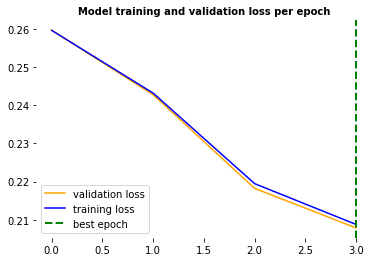

In [14]:
fig, ax = plt.subplots()
#fig.set_size_inches(30.5, 15.5)

plt.plot(validation_losses,color='orange',label='validation loss')
plt.plot(train_losses,color='blue',label='training loss')

plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed',label='best epoch')
#plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])
plt.legend()


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation loss per epoch", fontsize=10, fontweight='bold')
#plt.ylim(0.05,0.2)
# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/{folder_pkl}/model_loss_{model_list[sel_alg]}_view_{view}.png')
plt.show()

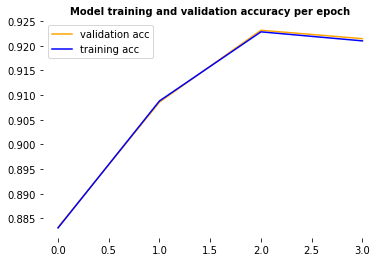

In [15]:
fig, ax = plt.subplots()
#fig.set_size_inches(30.5, 15.5)

plt.plot(validation_accuracies,color='orange',label='validation acc')
plt.plot(train_accuracies,color='blue',label='training acc')

plt.legend()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation accuracy per epoch", fontsize=10, fontweight='bold')
# plt.ylim(0.9,1)
# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/{folder_pkl}/model_acc_{model_list[sel_alg]}_view_{view}.png')
plt.show()